In [4]:
!pip install scikit-optimize -q

     |████████████████████████████████| 100 kB 7.0 MB/s 


In [5]:
# import all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics as metrics
from sklearn.metrics import f1_score

from skopt import BayesSearchCV

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall


import warnings
warnings.filterwarnings("ignore")

In [8]:
# function to laod the dataset and give the features and labels
def load_data(csv_file_path):
  print('loading the data...')
  # load the data frame from csv file
  data_frame = pd.read_csv(csv_file_path)
  
  # get our y from the data frame
  y = data_frame['Class']
  # get our X from the data frame
  X = data_frame.drop(columns = ['Class'], axis = 1)
  
  num_features = len(X.columns)
  num_samples = len(y)

  # print statistics
  print(f'The total number of samples in the dataset is: {num_samples}')
  print(f'The total number of features per sample is: {num_features}')

  return (X, y)

# split the data into train, test and validation sets
def split_data(X, y, test_size, val_size):
  
  print("\nsplitting the data...")
  # split the data into training_validation and testing sets with stratification
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_size, stratify=y)

  # split the training and validation sets with stratification
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = val_size, stratify = y_train_val)

  train_data = (X_train, y_train)
  val_data = (X_val, y_val)
  test_data = (X_test, y_test)

  # print statistics
  print(f'The number of training samples is: {len(y_train)}')
  print(f'The number of validation samples is: {len(y_val)}')
  print(f'The number of testing samples is: {len(y_test)}')
  
  return (train_data, val_data, test_data)

# function to increase the samples in the minority class
def over_sample_training_data(X, y, class_size_ratio):
  
  # create a SMOTE that produces minority samples to around the specified size of majority class 
  sm = sm = SMOTE(sampling_strategy= class_size_ratio)
  X_res, y_res = sm.fit_resample(X, y)

  return (X_res, y_res)


# function to plot historgrams of class labels before and after over sampling
def plot_bars(y_train, y_train_ovr):
  
  y_train_1s = np.sum(y_train)
  y_train_0s = len(y_train) - np.sum(y_train)

  y_train_ovr_1s = np.sum(y_train_ovr)
  y_train_ovr_0s = len(y_train_ovr) - y_train_ovr_1s

  fig, ax = plt.subplots(1, 2, figsize=(10,7))
  ax[0].bar(['0', '1'], [y_train_0s, y_train_1s], color = ['green', 'red'])
  ax[0].title.set_text("Before over sampling")
  ax[1].bar(['0', '1'], [y_train_ovr_0s, y_train_ovr_1s], color = ['green', 'red'])
  ax[1].title.set_text("After over sampling")

  fig.savefig('histograms.png')
  
  plt.show()


# normalize data without data leakage
def normalize_data(features):
  
  # get the standardization object
  scaler = StandardScaler()

  # fit the scaler to our features and get the transformed features
  standardized_features = scaler.fit_transform(features)

  return standardized_features

#function to tune the hyperparameters using bayesian search and 
# get the best best parameters that achieves the highest score
def tune_hyper_parameters(estimator, params, X, y, metric):

  # set the kfolds for cross-validation
  cv = StratifiedKFold(n_splits=2)

  # define the search parameters with average precision as scoring criteria
  search = BayesSearchCV(estimator, search_spaces=params, scoring = metric, n_jobs=-1, cv=cv, verbose = 0)

  # search
  print("Searching for the best parameters... ")
  search.fit(X, y)

  # print statistics
  print(f'The {metric} score for the best model is: {search.best_score_}') 
  
  print("\nThe best parameters found are: ")
  for (param, value) in search.best_params_.items():
    print(f'\t{param}: {value}')

  return search.best_estimator_


In [6]:
# download the dataset from public google drive link
# if this doesn't work use the creditcard.csv file 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p3M0qxdxiWG_WHiwxNKPC5Gdj0vnclPC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p3M0qxdxiWG_WHiwxNKPC5Gdj0vnclPC" -O creditcard.csv && rm -rf /tmp/cookies.txt


--2022-12-18 01:00:08--  https://docs.google.com/uc?export=download&confirm=t&id=1p3M0qxdxiWG_WHiwxNKPC5Gdj0vnclPC
Resolving docs.google.com (docs.google.com)... 142.250.145.100, 142.250.145.101, 142.250.145.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.145.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-14-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h7b4aht1najdhfkl56usbhti006f5eje/1671325200000/05548483623285552271/*/1p3M0qxdxiWG_WHiwxNKPC5Gdj0vnclPC?e=download&uuid=bcd2e227-937a-48b8-a98f-f03f5a7b1e19 [following]
--2022-12-18 01:00:08--  https://doc-00-14-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h7b4aht1najdhfkl56usbhti006f5eje/1671325200000/05548483623285552271/*/1p3M0qxdxiWG_WHiwxNKPC5Gdj0vnclPC?e=download&uuid=bcd2e227-937a-48b8-a98f-f03f5a7b1e19
Resolving doc-00-14-docs.googleusercontent.com (doc-00-14-docs.googleusercontent.com)... 142.250.153.

loading the data...
The total number of samples in the dataset is: 284807
The total number of features per sample is: 30

splitting the data...
The number of training samples is: 182276
The number of validation samples is: 45569
The number of testing samples is: 56962


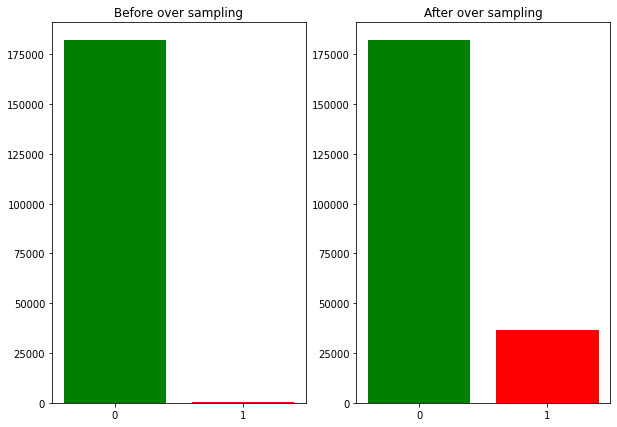

In [9]:
csv_file_path = 'creditcard.csv'
test_size = 0.2
val_size = 0.2
class_size_ratio = 0.2


# search parameters 

# metric

metric = 'f1_weighted'


# logistic regression

logistic_params = {
    'solver' : ['newton-cg', 'lbfgs' ],
    'C' : [0.5, 1]
}

# SVM

svm_params = {
    'kernel' : ['linear', 'rbf'], 
     'C' : [0.5, 1]
}

# adaBoost

ada_params = {
    'n_estimators' : (10, 50)

}


X, y = load_data(csv_file_path)
train_data, val_data, test_data = split_data(X, y, test_size, val_size)

(X_train, y_train) = train_data
(X_val, y_val) = val_data
(X_test, y_test) = test_data

X_train_ovr, y_train_ovr = over_sample_training_data(X_train, y_train, class_size_ratio)
plot_bars(y_train, y_train_ovr)

# standardize the data before training
X_train_ovr_std = normalize_data(X_train_ovr)

# standardize the test data seperately to prevent data lekage
X_test_std = normalize_data(X_test)


Searching for the best parameters... 
The f1_weighted score for the best model is: 0.9877779331071871

The best parameters found are: 
	C: 0.9615277348033873
	solver: newton-cg


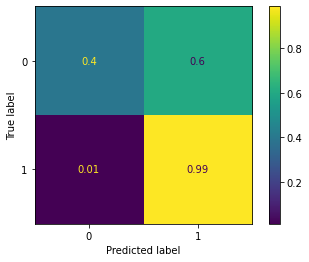

CPU times: user 1min 21s, sys: 50.4 s, total: 2min 11s
Wall time: 4min 31s


In [6]:
%%time

logistic_estimator = LogisticRegression()

best_logistic_model = tune_hyper_parameters(logistic_estimator, logistic_params, X_train_ovr_std, y_train_ovr, metric)

metrics.ConfusionMatrixDisplay.from_estimator(best_logistic_model, X_test_std, y_test, normalize='true')
plt.show()

Searching for the best parameters... 
The f1_weighted score for the best model is: 0.9964641596379016

The best parameters found are: 
	C: 1.0
	kernel: rbf


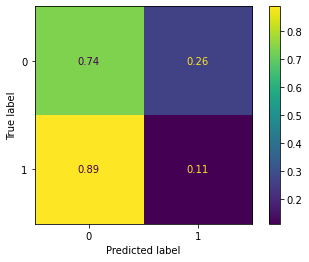

CPU times: user 3min 35s, sys: 51.3 s, total: 4min 27s
Wall time: 1h 58min 31s


In [7]:
%%time

svm_estimator = SVC()

best_svm_model = tune_hyper_parameters(svm_estimator, svm_params, X_train_ovr_std, y_train_ovr, metric)

metrics.ConfusionMatrixDisplay.from_estimator(best_svm_model, X_test_std, y_test, normalize='true')
plt.show()

Searching for the best parameters... 
The f1_weighted score for the best model is: 0.990185526843095

The best parameters found are: 
	n_estimators: 50


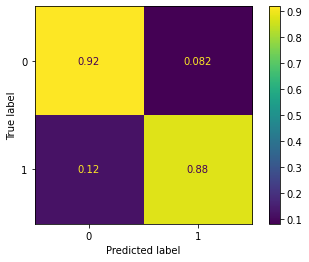

CPU times: user 2min 17s, sys: 40.9 s, total: 2min 58s
Wall time: 32min 52s


In [14]:
%%time

ada_estimator = AdaBoostClassifier()

best_ada_model = tune_hyper_parameters(ada_estimator, ada_params, X_train_ovr_std, y_train_ovr, metric)

metrics.ConfusionMatrixDisplay.from_estimator(best_ada_model, X_test_std, y_test, normalize='true')
plt.show()

In [15]:
%%time 

input = Input((30))
x = Dense(32, activation='relu')(input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(8, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(4, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

history = model.fit(x=X_train_ovr_std, 
                    y=y_train_ovr, 
                    epochs = 5, 
                    batch_size = 128,
                    validation_data=(X_val, y_val))

Epoch 1/5
1706/1706 [==============================] - 9s 4ms/step - loss: 0.1392 - accuracy: 0.9659 - val_loss: 3.0346 - val_accuracy: 0.9983
Epoch 2/5
1706/1706 [==============================] - 7s 4ms/step - loss: 0.0438 - accuracy: 0.9886 - val_loss: 14.4228 - val_accuracy: 0.9983
Epoch 3/5
1706/1706 [==============================] - 7s 4ms/step - loss: 0.0342 - accuracy: 0.9906 - val_loss: 35.7414 - val_accuracy: 0.9983
Epoch 4/5
1706/1706 [==============================] - 7s 4ms/step - loss: 0.0283 - accuracy: 0.9922 - val_loss: 64.3214 - val_accuracy: 0.9983
Epoch 5/5
1706/1706 [==============================] - 7s 4ms/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 105.3612 - val_accuracy: 0.9983
CPU times: user 43.9 s, sys: 2.34 s, total: 46.3 s
Wall time: 42.8 s


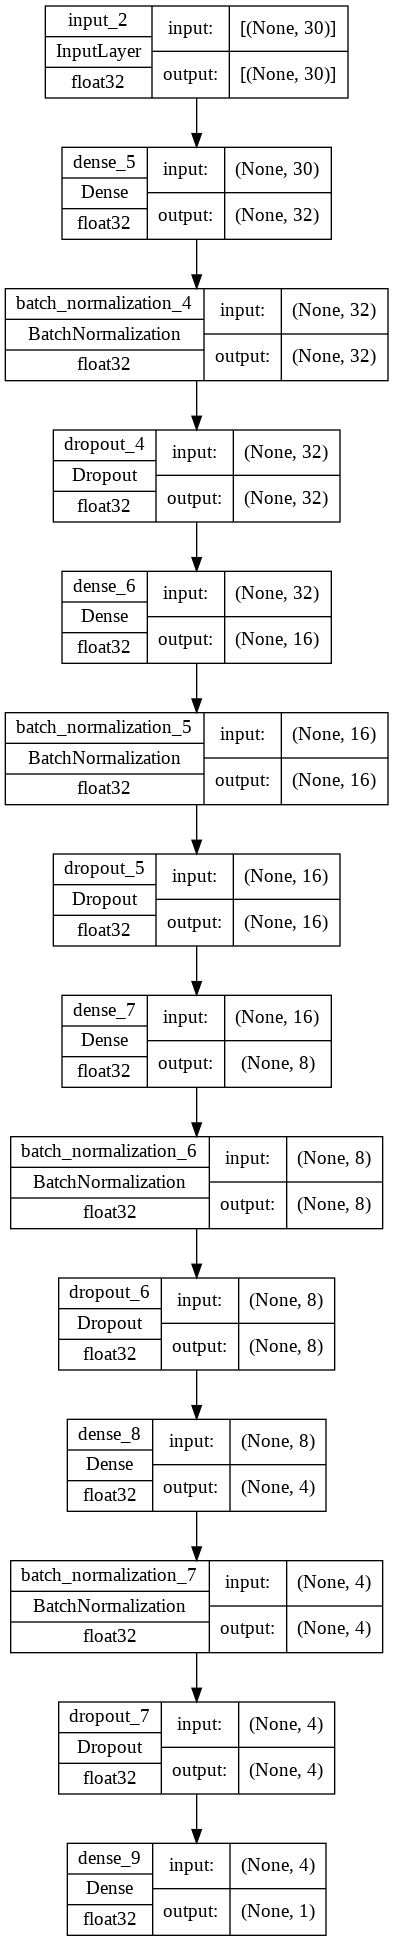

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_5 (Dense)             (None, 32)                992       
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_5 (Batc  (None, 16)               64        
 hNormalization)                                           

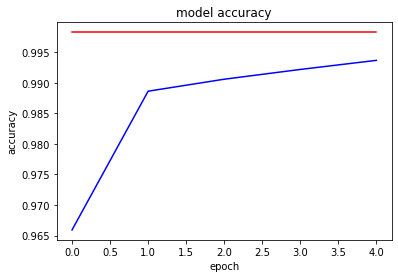

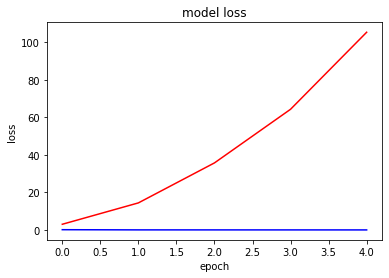

In [18]:
# plots

plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

1781/1781 [==============================] - 3s 2ms/step
The weighted f-1 score 0.6946078018813837


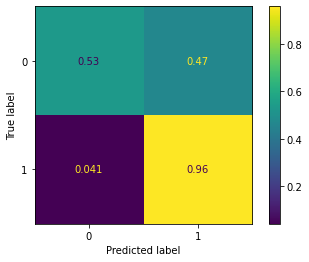

In [19]:
# get the model's predictions on the test set
y_pred = model.predict(X_test_std)
# convert the predicted scores to 0's and 1's
y_pred = (y_pred > 0.5)*1

print(f"The weighted f-1 score {f1_score(y_test, y_pred, average='weighted')}")

# plot the confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()